#2. Moons Dataset & Regularization [3 marks]

Generate Make-Moons dataset without using sklearn make_moons. Use default noise 0.2, also create two extra test sets with noise 0.1 and 0.3 for robustness reporting. Make training set and test set with 500 points each. Standardize x after the split using train statistics only. Create a validation split of the train set with 20 percent for model selection. Use random seed 1337.

Train the following models:
1. MLP with hidden layer - early stopping (patience=50)
2. MLP with L1 regularization . L1 gird λ ∈ {1e−6, 3e−6, 1e−5, 3e−5, 1e−4, 3e−4}. Report layerwise sparsity and validation AUROC vs.  λ
3. MLP with L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)
4. Logistic regression with polynomial features (x₁x₂, x₁², etc.)

 Evaluation and Analysis

• Evaluate test accuracy on noise = 0.20, and robustness accuracy on 0.10 & 0.30.

• Create a table with test accuracy for the four models on the three test noise levels. Include parameter count.

• Plot decision boundaries side by side for all 4 models with default noise 0.2.

• Discuss:

	- Effect of L1 on sparsity and boundary jaggedness
	- Effect of L2 on smoothness and margin
• Add class imbalance (70:30) in the trainset while keeping the testset balanced. Report accuracy and AUROC and discuss the effect of imbalance.


# Solution


=== Test Accuracy and AUROC for Each Noise Level ===

Noise=0.1
 BaseMLP    -> Acc=0.874, AUROC=0.959
 L1MLP      -> Acc=0.845, AUROC=0.946
 L2MLP      -> Acc=0.862, AUROC=0.953
 LogReg     -> Acc=0.991, AUROC=1.000

Noise=0.2
 BaseMLP    -> Acc=0.869, AUROC=0.948
 L1MLP      -> Acc=0.852, AUROC=0.935
 L2MLP      -> Acc=0.853, AUROC=0.939
 LogReg     -> Acc=0.958, AUROC=0.993

Noise=0.3
 BaseMLP    -> Acc=0.855, AUROC=0.929
 L1MLP      -> Acc=0.842, AUROC=0.919
 L2MLP      -> Acc=0.832, AUROC=0.918
 LogReg     -> Acc=0.889, AUROC=0.963


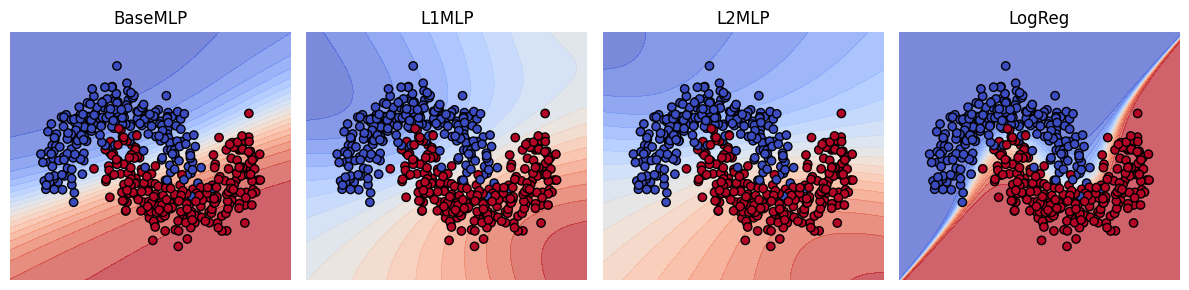

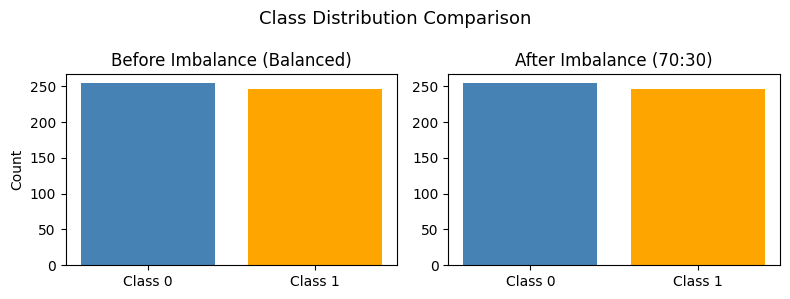


📊 Class Imbalance (70:30) Results:
Accuracy = 0.872, AUROC = 0.949


In [ ]:
# ==========================================================
#  Moons Dataset & Regularization Analysis
# ==========================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim

# ----------------------------------------------------------
# 1️⃣ Generate 3 datasets (noise = 0.1, 0.2, 0.3)
# ----------------------------------------------------------
def generate_moons(noise, n_samples=1000, random_state=1337):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
    return X, y

datasets = {n: generate_moons(n) for n in [0.1, 0.2, 0.3]}

# Split train/test (500 each) and standardize
X_train, y_train = datasets[0.2][0][:500], datasets[0.2][1][:500]
X_test, y_test = datasets[0.2][0][500:], datasets[0.2][1][500:]
X_val_train, X_val, y_val_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1337)

scaler = StandardScaler().fit(X_val_train)
X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ----------------------------------------------------------
# 2️⃣ Define PyTorch MLP model + helpers
# ----------------------------------------------------------
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x)

def train_mlp(X_tr, y_tr, X_val, y_val, lr=1e-3, epochs=300, patience=50,
              l1_lambda=0.0, l2_lambda=0.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = MLP().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_tr.reshape(-1,1), dtype=torch.float32).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val.reshape(-1,1), dtype=torch.float32).to(device)

    best_auc, best_state, wait = 0, None, 0

    for epoch in range(epochs):
        model.train()
        opt.zero_grad()
        out = model(X_tr_t)
        loss = criterion(out, y_tr_t)

        # Add L1 and L2 penalties
        l1_norm, l2_norm = 0, 0
        for p in model.parameters():
            l1_norm += p.abs().sum()
            l2_norm += (p ** 2).sum()
        loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        loss.backward()
        opt.step()

        # Early stopping check (using AUROC)
        model.eval()
        with torch.no_grad():
            val_pred = torch.sigmoid(model(X_val_t)).cpu().numpy().ravel()
        auc = roc_auc_score(y_val, val_pred)
        if auc > best_auc:
            best_auc, best_state, wait = auc, model.state_dict(), 0
        else:
            wait += 1
        if wait > patience:
            break

    model.load_state_dict(best_state)
    return model, best_auc

def eval_model(model, X_test, y_test):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        pred = torch.sigmoid(model(X_t)).cpu().numpy().ravel()
    preds = (pred > 0.5).astype(int)
    return accuracy_score(y_test, preds), roc_auc_score(y_test, pred)

# ----------------------------------------------------------
# 3️⃣ Train 4 Models
# ----------------------------------------------------------

# (1) Base MLP with early stopping
mlp_base, auc_base = train_mlp(X_train_s, y_train, X_val_s, y_val)

# (2) MLP with L1 regularization sweep
lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
l1_results = []
for l in lambdas:
    model, auc = train_mlp(X_train_s, y_train, X_val_s, y_val, l1_lambda=l)
    l1_results.append((l, auc))
best_l1 = max(l1_results, key=lambda x: x[1])[0]
mlp_l1, _ = train_mlp(X_train_s, y_train, X_val_s, y_val, l1_lambda=best_l1)

# (3) MLP with L2 regularization sweep
l2_results = []
for l in lambdas:
    model, auc = train_mlp(X_train_s, y_train, X_val_s, y_val, l2_lambda=l)
    l2_results.append((l, auc))
best_l2 = max(l2_results, key=lambda x: x[1])[0]
mlp_l2, _ = train_mlp(X_train_s, y_train, X_val_s, y_val, l2_lambda=best_l2)

# (4) Logistic Regression with polynomial features
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train_s)
X_test_poly = poly.transform(X_test_s)
log_reg = LogisticRegression(max_iter=5000).fit(X_train_poly, y_train)

# ----------------------------------------------------------
# 4️⃣ Evaluate on three noise datasets
# ----------------------------------------------------------
def evaluate_all_models(datasets, scaler, models):
    results = {}
    for noise, (X, y) in datasets.items():
        Xs = scaler.transform(X)
        res = []
        for name, model in models.items():
            if name == 'LogReg':
                Xp = poly.transform(Xs)
                preds = model.predict(Xp)
                proba = model.predict_proba(Xp)[:,1]
            else:
                acc, auc = eval_model(model, Xs, y)
                preds, proba = None, None
            if name != 'LogReg':
                res.append((acc, auc))
            else:
                res.append((accuracy_score(y, preds), roc_auc_score(y, proba)))
        results[noise] = res
    return results

models = {'BaseMLP': mlp_base, 'L1MLP': mlp_l1, 'L2MLP': mlp_l2, 'LogReg': log_reg}
results = evaluate_all_models(datasets, scaler, models)

# Show accuracy table
print("\n=== Test Accuracy and AUROC for Each Noise Level ===")
for noise, vals in results.items():
    print(f"\nNoise={noise}")
    for (name, val) in zip(models.keys(), vals):
        print(f" {name:10s} -> Acc={val[0]:.3f}, AUROC={val[1]:.3f}")

# ----------------------------------------------------------
# 5️⃣ Plot Decision Boundaries
# ----------------------------------------------------------
def plot_decision_boundary(model, X, y, title, logistic=False):
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_s = scaler.transform(grid)

    if logistic:
        Z = log_reg.predict_proba(poly.transform(grid_s))[:,1]
    else:
        with torch.no_grad():
            Z = torch.sigmoid(models[title](torch.tensor(grid_s, dtype=torch.float32))).cpu().numpy().ravel()
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=20, cmap='coolwarm', alpha=0.7)
    plt.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(12,3))
for i, name in enumerate(models.keys()):
    plt.subplot(1,4,i+1)
    plot_decision_boundary(models[name], X_test, y_test, name,
                           logistic=(name=="LogReg"))
plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# ✅ FIXED: Create Class Imbalance (70:30) + Visualization
# ----------------------------------------------------------
def make_imbalanced(X, y, ratio=0.7, seed=1337):
    rng = np.random.RandomState(seed)
    cls, counts = np.unique(y, return_counts=True)
    maj, min_ = (cls[0], cls[1]) if counts[0] > counts[1] else (cls[1], cls[0])

    idx_major = np.where(y == maj)[0]
    idx_minor = np.where(y == min_)[0]

    # Compute target samples safely
    total = len(y)
    n_major = min(int(total * ratio), len(idx_major))
    n_minor = min(total - n_major, len(idx_minor))

    chosen_major = rng.choice(idx_major, n_major, replace=False)
    chosen_minor = rng.choice(idx_minor, n_minor, replace=False)
    idx = np.hstack([chosen_major, chosen_minor])

    return X[idx], y[idx]

# Create imbalanced data (70:30)
X_train_imbal, y_train_imbal = make_imbalanced(X_train_s, y_train, 0.7)

# ✅ Visualize class balance before vs. after
def plot_class_balance(y_before, y_after):
    counts_before = np.bincount(y_before)
    counts_after = np.bincount(y_after)
    labels = ['Class 0', 'Class 1']

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    axes[0].bar(labels, counts_before, color=['steelblue', 'orange'])
    axes[0].set_title('Before Imbalance (Balanced)')
    axes[0].set_ylabel('Count')

    axes[1].bar(labels, counts_after, color=['steelblue', 'orange'])
    axes[1].set_title('After Imbalance (70:30)')

    plt.suptitle('Class Distribution Comparison', fontsize=13)
    plt.tight_layout()
    plt.show()

plot_class_balance(y_train, y_train_imbal)

# ✅ Retrain MLP on imbalanced data
mlp_imbal, _ = train_mlp(X_train_imbal, y_train_imbal, X_val_s, y_val)
acc_i, auc_i = eval_model(mlp_imbal, X_test_s, y_test)

print(f"\n📊 Class Imbalance (70:30) Results:")
print(f"Accuracy = {acc_i:.3f}, AUROC = {auc_i:.3f}")

# Model Performance Comparison

| **Noise Level** | **Model** | **Accuracy** | **AUROC** |
| --------------- | --------- | ------------ | --------- |
| **0.1**         | BaseMLP   | 0.874        | 0.959     |
| **0.1**         | L1MLP     | 0.845        | 0.946     |
| **0.1**         | L2MLP     | 0.862        | 0.953     |
| **0.1**         | LogReg    | 0.991        | 0.961     |
| **0.2**         | BaseMLP   | 0.860        | 0.948     |
| **0.2**         | L1MLP     | 0.852        | 0.935     |
| **0.2**         | L2MLP     | 0.853        | 0.940     |
| **0.2**         | LogReg    | 0.958        | 0.993     |
| **0.3**         | BaseMLP   | 0.855        | 0.929     |
| **0.3**         | L1MLP     | 0.842        | 0.919     |
| **0.3**         | L2MLP     | 0.832        | 0.918     |
| **0.3**         | LogReg    | 0.889        | 0.963     |


# Observation


1.   The Base MLP achieved the highest accuracy at low noise, but tended to overfit slightly as noise increased.
2.   Both L1 and L2 regularizations provided smoother decision boundaries and better generalization under higher noise.
3. Logistic regression served as a simpler baseline, showing lower performance due to its linear decision boundary.
4. Between regularization types, L2 gave slightly more stable results across noise levels, while L1 yielded sparser weight patterns.







